In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns

from datetime import datetime
from scipy.optimize import minimize
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer, StandardScaler
from surprise import SVD, accuracy, Dataset, Reader

In [2]:
train = pd.read_csv('train.csv')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3123064 entries, 0 to 3123063
Data columns (total 3 columns):
 #   Column              Dtype 
---  ------              ----- 
 0   user_id             int64 
 1   order_completed_at  object
 2   cart                int64 
dtypes: int64(2), object(1)
memory usage: 71.5+ MB


In [3]:
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission

,id,target
0,0;133,0
1,0;5,1
2,0;10,0
3,0;396,1
4,0;14,0
...,...,...
790444,19998;26,0
790445,19998;31,0
790446,19998;29,1
790447,19998;798,1


Моя первая задача - составить выборку, на которой можно будет тестировать модели. Для этого нужно выделить последние заказы каждого пользователя.

In [9]:
# Словарь, в котором хранится номер заказа для пользователя в обратном порядке.
# Предварительно я убедилась, что время каждого заказа уникально.
def order_number(df):
    orders = dict()
    for user in df.user_id.unique():
        num = {y:x for x, y in enumerate(sorted(train[train.user_id==user]['order_completed_at'].unique(), reverse=True))}
        orders.update(num)
    return orders

In [10]:
orders = order_number(train)
orders

{'2020-06-18 18:31:08': 0,
 '2020-01-11 16:50:15': 1,
 '2019-12-22 14:57:39': 2,
 '2019-12-10 14:09:13': 3,
 '2019-11-27 14:07:14': 4,
 '2019-11-13 19:05:45': 5,
 '2019-11-09 20:45:19': 6,
 '2019-11-02 22:00:26': 7,
 '2019-10-25 21:05:56': 8,
 '2019-10-15 06:35:13': 9,
 '2019-10-11 09:05:20': 10,
 '2019-10-03 17:37:23': 11,
 '2018-01-12 23:36:19': 12,
 '2016-05-27 19:21:46': 13,
 '2015-03-22 09:25:46': 14,
 '2020-06-24 13:07:29': 0,
 '2020-06-12 14:49:01': 1,
 '2020-04-12 10:57:57': 2,
 '2015-11-27 19:37:17': 3,
 '2015-08-12 10:33:44': 4,
 '2015-07-04 14:05:22': 5,
 '2015-06-18 16:15:33': 6,
 '2020-08-27 13:54:48': 0,
 '2020-06-21 07:07:52': 1,
 '2020-06-01 16:01:06': 2,
 '2020-05-02 13:19:22': 3,
 '2020-04-26 08:25:26': 4,
 '2020-04-21 10:14:51': 5,
 '2020-04-18 06:36:22': 6,
 '2015-07-08 06:59:04': 7,
 '2020-08-29 09:56:56': 0,
 '2020-08-17 14:51:41': 1,
 '2020-08-16 15:37:08': 2,
 '2020-07-30 15:31:40': 3,
 '2020-07-16 19:40:55': 4,
 '2020-07-16 12:17:06': 5,
 '2020-07-08 17:35:01':

In [11]:
#Добавляю номер заказа в датасет
train['orders_num'] = train.apply(lambda x: orders[x.order_completed_at], axis=1)
train

,user_id,order_completed_at,cart,orders_num
0,2,2015-03-22 09:25:46,399,14
1,2,2015-03-22 09:25:46,14,14
2,2,2015-03-22 09:25:46,198,14
3,2,2015-03-22 09:25:46,88,14
4,2,2015-03-22 09:25:46,157,14
...,...,...,...,...
3123059,12702,2020-09-03 23:45:45,441,0
3123060,12702,2020-09-03 23:45:45,92,0
3123061,12702,2020-09-03 23:45:45,431,0
3123062,12702,2020-09-03 23:45:45,24,0


In [12]:
# Нулевые заказы идут в тестовую выборку
test = train[train.orders_num == 0].drop_duplicates()

In [13]:
#На остальных заказах буду учить модели
small_train = train[train.orders_num != 0]
small_train

,user_id,order_completed_at,cart,orders_num
0,2,2015-03-22 09:25:46,399,14
1,2,2015-03-22 09:25:46,14,14
2,2,2015-03-22 09:25:46,198,14
3,2,2015-03-22 09:25:46,88,14
4,2,2015-03-22 09:25:46,157,14
...,...,...,...,...
3122320,10497,2020-09-03 20:03:55,393,1
3122321,10497,2020-09-03 20:03:55,409,1
3122322,10497,2020-09-03 20:03:55,17,1
3122323,10497,2020-09-03 20:03:55,57,1


Делаю новые признаки на выборке small_train. Ниже их полный список с разбивкой по группам: относятся они к пользователю, к продукту или к паре

### user
1. *orders_num* - порядковый номер заказа для пользователя(в реверсивном порядке)
1. *count_orders* - количество заказов у данного пользователя
1. *orders_freq* - средний интервал между заказами пользователя
1. *last_order_time* - насколько далеко последний заказ пользователя отстоит от 3 сентябя 2020 г. (в днях)
1. *first_order_time* - насколько далеко первый заказ пользователя отстоит от 3 сентября 202 г. (в днях)
1. *hour* - среднее время суток (в часах), когда данный пользователь делает заказы
1. *user_cart* - сколько покупок совершил пользователь за все время
1. *carts_in_order* - сколько в среднем продуктов в заказе пользователя
1. *conservativity* - доля повторных покупок в общем числе покупок пользователя

### product
1. *popularity* - доля покупок данного продукта в общем числе покупок

### both
1. *matches* - сколько раз данный пользователь купил данный продукт
1. *user_love* - доля покупок данного продукта в общем числе покупок пользователя



In [35]:
user_activity = small_train[['user_id', 'order_completed_at']].drop_duplicates().groupby(['user_id']).count().reset_index()
user_activity.rename(columns={'order_completed_at': 'count_orders'}, inplace=True)

small_train = small_train.merge(user_activity, how='left', on='user_id')
small_train

,user_id,order_completed_at,cart,orders_num,orders_freq,last_order_time,first_order_time,hour,user_cart,count_orders
0,2,2015-03-22 09:25:46,399,14,135.076923,236,1992,16.329762,165,14
1,2,2015-03-22 09:25:46,14,14,135.076923,236,1992,16.329762,165,14
2,2,2015-03-22 09:25:46,198,14,135.076923,236,1992,16.329762,165,14
3,2,2015-03-22 09:25:46,88,14,135.076923,236,1992,16.329762,165,14
4,2,2015-03-22 09:25:46,157,14,135.076923,236,1992,16.329762,165,14
...,...,...,...,...,...,...,...,...,...,...
2842424,10497,2020-09-03 20:03:55,393,1,80.000000,0,160,13.127778,21,3
2842425,10497,2020-09-03 20:03:55,409,1,80.000000,0,160,13.127778,21,3
2842426,10497,2020-09-03 20:03:55,17,1,80.000000,0,160,13.127778,21,3
2842427,10497,2020-09-03 20:03:55,57,1,80.000000,0,160,13.127778,21,3


In [17]:
#orders_freq
frequency = dict()
for user in small_train.user_id.unique():
    count_orders = small_train[small_train.user_id==user]['orders_num'].max()
    fin = datetime.strptime(small_train[small_train.user_id==user]['order_completed_at'].max(), '%Y-%m-%d %H:%M:%S')
    end = datetime.strptime(small_train[small_train.user_id==user]['order_completed_at'].min(), '%Y-%m-%d %H:%M:%S')
    delta = fin - end
    try:
        value = delta.days / (count_orders - 1)
    except ZeroDivisionError:
        value = 0
    frequency[user] = value

In [18]:
small_train['orders_freq'] = small_train.apply(lambda x: frequency[x.user_id], axis=1)
small_train

C:\Users\Solnotka\AppData\Local\Temp/ipykernel_8472/2737206365.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_train['orders_freq'] = small_train.apply(lambda x: frequency[x.user_id], axis=1)


,user_id,order_completed_at,cart,orders_num,orders_freq
0,2,2015-03-22 09:25:46,399,14,135.076923
1,2,2015-03-22 09:25:46,14,14,135.076923
2,2,2015-03-22 09:25:46,198,14,135.076923
3,2,2015-03-22 09:25:46,88,14,135.076923
4,2,2015-03-22 09:25:46,157,14,135.076923
...,...,...,...,...,...
3122320,10497,2020-09-03 20:03:55,393,1,80.000000
3122321,10497,2020-09-03 20:03:55,409,1,80.000000
3122322,10497,2020-09-03 20:03:55,17,1,80.000000
3122323,10497,2020-09-03 20:03:55,57,1,80.000000


In [19]:
small_train['orders_freq'].describe()

count    2.842429e+06
mean     1.831014e+01
std      2.476143e+01
min      0.000000e+00
25%      7.500000e+00
50%      1.173333e+01
75%      2.050000e+01
max      1.433000e+03
Name: orders_freq, dtype: float64

In [21]:
#last_order_time
last_order_time = dict()
for user in small_train.user_id.unique():
    date = datetime.strptime('2020-09-04 00:00:00', '%Y-%m-%d %H:%M:%S')
    last = datetime.strptime(small_train[small_train.user_id==user]['order_completed_at'].max(), '%Y-%m-%d %H:%M:%S')
    value = (date - last).days
    last_order_time[user] = value

In [22]:
small_train['last_order_time'] = small_train.apply(lambda x: last_order_time[x.user_id], axis=1)
small_train

C:\Users\Solnotka\AppData\Local\Temp/ipykernel_8472/758375835.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_train['last_order_time'] = small_train.apply(lambda x: last_order_time[x.user_id], axis=1)


,user_id,order_completed_at,cart,orders_num,orders_freq,last_order_time
0,2,2015-03-22 09:25:46,399,14,135.076923,236
1,2,2015-03-22 09:25:46,14,14,135.076923,236
2,2,2015-03-22 09:25:46,198,14,135.076923,236
3,2,2015-03-22 09:25:46,88,14,135.076923,236
4,2,2015-03-22 09:25:46,157,14,135.076923,236
...,...,...,...,...,...,...
3122320,10497,2020-09-03 20:03:55,393,1,80.000000,0
3122321,10497,2020-09-03 20:03:55,409,1,80.000000,0
3122322,10497,2020-09-03 20:03:55,17,1,80.000000,0
3122323,10497,2020-09-03 20:03:55,57,1,80.000000,0


In [23]:
#first_order_time
first_order_time = dict()
for user in small_train.user_id.unique():
    date = datetime.strptime('2020-09-04 00:00:00', '%Y-%m-%d %H:%M:%S')
    first = datetime.strptime(small_train[small_train.user_id==user]['order_completed_at'].min(), '%Y-%m-%d %H:%M:%S')
    value = (date - first).days
    first_order_time[user] = value

In [24]:
small_train['first_order_time'] = small_train.apply(lambda x: first_order_time[x.user_id], axis=1)
small_train

C:\Users\Solnotka\AppData\Local\Temp/ipykernel_8472/3902918968.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_train['first_order_time'] = small_train.apply(lambda x: first_order_time[x.user_id], axis=1)


,user_id,order_completed_at,cart,orders_num,orders_freq,last_order_time,first_order_time
0,2,2015-03-22 09:25:46,399,14,135.076923,236,1992
1,2,2015-03-22 09:25:46,14,14,135.076923,236,1992
2,2,2015-03-22 09:25:46,198,14,135.076923,236,1992
3,2,2015-03-22 09:25:46,88,14,135.076923,236,1992
4,2,2015-03-22 09:25:46,157,14,135.076923,236,1992
...,...,...,...,...,...,...,...
3122320,10497,2020-09-03 20:03:55,393,1,80.000000,0,160
3122321,10497,2020-09-03 20:03:55,409,1,80.000000,0,160
3122322,10497,2020-09-03 20:03:55,17,1,80.000000,0,160
3122323,10497,2020-09-03 20:03:55,57,1,80.000000,0,160


In [27]:
#Среднее время заказа (в часах)
small_train['hour'] = small_train.apply(lambda x: datetime.strptime(x.order_completed_at, '%Y-%m-%d %H:%M:%S').hour, axis=1)
small_train

C:\Users\Solnotka\AppData\Local\Temp/ipykernel_8472/3537939264.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_train['hour'] = small_train.apply(lambda x: datetime.strptime(x.order_completed_at, '%Y-%m-%d %H:%M:%S').hour, axis=1)


,user_id,order_completed_at,cart,orders_num,orders_freq,last_order_time,first_order_time,hour
0,2,2015-03-22 09:25:46,399,14,135.076923,236,1992,9
1,2,2015-03-22 09:25:46,14,14,135.076923,236,1992,9
2,2,2015-03-22 09:25:46,198,14,135.076923,236,1992,9
3,2,2015-03-22 09:25:46,88,14,135.076923,236,1992,9
4,2,2015-03-22 09:25:46,157,14,135.076923,236,1992,9
...,...,...,...,...,...,...,...,...
3122320,10497,2020-09-03 20:03:55,393,1,80.000000,0,160,20
3122321,10497,2020-09-03 20:03:55,409,1,80.000000,0,160,20
3122322,10497,2020-09-03 20:03:55,17,1,80.000000,0,160,20
3122323,10497,2020-09-03 20:03:55,57,1,80.000000,0,160,20


In [29]:
order_time = dict()
for user in small_train.user_id.unique():
    datesum = 0
    count_orders = small_train[small_train.user_id==user]['orders_num'].max()
    for order in small_train[small_train.user_id==user]['order_completed_at'].drop_duplicates():
        hours = datetime.strptime(order, '%Y-%m-%d %H:%M:%S').hour
        minutes = datetime.strptime(order, '%Y-%m-%d %H:%M:%S').minute
        datesum += hours * 60
        datesum += minutes
    order_time[user] = datesum / count_orders / 60

In [30]:
small_train['hour'] = small_train.apply(lambda x: order_time[x.user_id], axis=1)
small_train

C:\Users\Solnotka\AppData\Local\Temp/ipykernel_8472/2544873668.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_train['hour'] = small_train.apply(lambda x: order_time[x.user_id], axis=1)


,user_id,order_completed_at,cart,orders_num,orders_freq,last_order_time,first_order_time,hour
0,2,2015-03-22 09:25:46,399,14,135.076923,236,1992,16.329762
1,2,2015-03-22 09:25:46,14,14,135.076923,236,1992,16.329762
2,2,2015-03-22 09:25:46,198,14,135.076923,236,1992,16.329762
3,2,2015-03-22 09:25:46,88,14,135.076923,236,1992,16.329762
4,2,2015-03-22 09:25:46,157,14,135.076923,236,1992,16.329762
...,...,...,...,...,...,...,...,...
3122320,10497,2020-09-03 20:03:55,393,1,80.000000,0,160,13.127778
3122321,10497,2020-09-03 20:03:55,409,1,80.000000,0,160,13.127778
3122322,10497,2020-09-03 20:03:55,17,1,80.000000,0,160,13.127778
3122323,10497,2020-09-03 20:03:55,57,1,80.000000,0,160,13.127778


In [32]:
#Сколько покупок совершил пользователь
user_cart = small_train[['user_id', 'cart']].groupby(['user_id']).count().reset_index()
user_cart.rename(columns={'cart': 'user_cart'}, inplace=True)

small_train = small_train.merge(user_cart, how='left', on='user_id')
small_train

,user_id,order_completed_at,cart,orders_num,orders_freq,last_order_time,first_order_time,hour,user_cart
0,2,2015-03-22 09:25:46,399,14,135.076923,236,1992,16.329762,165
1,2,2015-03-22 09:25:46,14,14,135.076923,236,1992,16.329762,165
2,2,2015-03-22 09:25:46,198,14,135.076923,236,1992,16.329762,165
3,2,2015-03-22 09:25:46,88,14,135.076923,236,1992,16.329762,165
4,2,2015-03-22 09:25:46,157,14,135.076923,236,1992,16.329762,165
...,...,...,...,...,...,...,...,...,...
2842424,10497,2020-09-03 20:03:55,393,1,80.000000,0,160,13.127778,21
2842425,10497,2020-09-03 20:03:55,409,1,80.000000,0,160,13.127778,21
2842426,10497,2020-09-03 20:03:55,17,1,80.000000,0,160,13.127778,21
2842427,10497,2020-09-03 20:03:55,57,1,80.000000,0,160,13.127778,21


In [36]:
#Сколько в среднем продуктов в заказе пользователя
small_train['carts_in_order'] = small_train.apply(lambda x: x.user_cart / x.count_orders, axis=1)

In [37]:
#Популярность продукта
popularity = small_train[['cart', 'user_id']].groupby(['cart']).count().reset_index()
popularity.rename(columns={'user_id': 'popularity'}, inplace=True)
small_train = small_train.merge(popularity, how='left', on='cart')
small_train['popularity'] = small_train.apply(lambda x: x.popularity / len(small_train), axis=1)
small_train

,user_id,order_completed_at,cart,orders_num,orders_freq,last_order_time,first_order_time,hour,user_cart,count_orders,carts_in_order,popularity
0,2,2015-03-22 09:25:46,399,14,135.076923,236,1992,16.329762,165,14,11.785714,0.004386
1,2,2015-03-22 09:25:46,14,14,135.076923,236,1992,16.329762,165,14,11.785714,0.029964
2,2,2015-03-22 09:25:46,198,14,135.076923,236,1992,16.329762,165,14,11.785714,0.005715
3,2,2015-03-22 09:25:46,88,14,135.076923,236,1992,16.329762,165,14,11.785714,0.011035
4,2,2015-03-22 09:25:46,157,14,135.076923,236,1992,16.329762,165,14,11.785714,0.004888
...,...,...,...,...,...,...,...,...,...,...,...,...
2842424,10497,2020-09-03 20:03:55,393,1,80.000000,0,160,13.127778,21,3,7.000000,0.004469
2842425,10497,2020-09-03 20:03:55,409,1,80.000000,0,160,13.127778,21,3,7.000000,0.019341
2842426,10497,2020-09-03 20:03:55,17,1,80.000000,0,160,13.127778,21,3,7.000000,0.018824
2842427,10497,2020-09-03 20:03:55,57,1,80.000000,0,160,13.127778,21,3,7.000000,0.034758


In [38]:
#Сколько раз данный пользователь купил данный продукт
matches = small_train[['user_id', 'cart', 'order_completed_at']].groupby(['user_id', 'cart']).count().reset_index()
matches.rename(columns={'order_completed_at': 'matches'}, inplace=True)
small_train = small_train.merge(matches, how='left', on=['user_id', 'cart'])
small_train

,user_id,order_completed_at,cart,orders_num,orders_freq,last_order_time,first_order_time,hour,user_cart,count_orders,carts_in_order,popularity,matches
0,2,2015-03-22 09:25:46,399,14,135.076923,236,1992,16.329762,165,14,11.785714,0.004386,1
1,2,2015-03-22 09:25:46,14,14,135.076923,236,1992,16.329762,165,14,11.785714,0.029964,1
2,2,2015-03-22 09:25:46,198,14,135.076923,236,1992,16.329762,165,14,11.785714,0.005715,2
3,2,2015-03-22 09:25:46,88,14,135.076923,236,1992,16.329762,165,14,11.785714,0.011035,2
4,2,2015-03-22 09:25:46,157,14,135.076923,236,1992,16.329762,165,14,11.785714,0.004888,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2842424,10497,2020-09-03 20:03:55,393,1,80.000000,0,160,13.127778,21,3,7.000000,0.004469,2
2842425,10497,2020-09-03 20:03:55,409,1,80.000000,0,160,13.127778,21,3,7.000000,0.019341,1
2842426,10497,2020-09-03 20:03:55,17,1,80.000000,0,160,13.127778,21,3,7.000000,0.018824,1
2842427,10497,2020-09-03 20:03:55,57,1,80.000000,0,160,13.127778,21,3,7.000000,0.034758,1


In [39]:
#Доля данного продукта в покупках пользователя
small_train['user_love'] = small_train.apply(lambda x: x.matches / x.user_cart, axis=1)
small_train

,user_id,order_completed_at,cart,orders_num,orders_freq,last_order_time,first_order_time,hour,user_cart,count_orders,carts_in_order,popularity,matches,user_love
0,2,2015-03-22 09:25:46,399,14,135.076923,236,1992,16.329762,165,14,11.785714,0.004386,1,0.006061
1,2,2015-03-22 09:25:46,14,14,135.076923,236,1992,16.329762,165,14,11.785714,0.029964,1,0.006061
2,2,2015-03-22 09:25:46,198,14,135.076923,236,1992,16.329762,165,14,11.785714,0.005715,2,0.012121
3,2,2015-03-22 09:25:46,88,14,135.076923,236,1992,16.329762,165,14,11.785714,0.011035,2,0.012121
4,2,2015-03-22 09:25:46,157,14,135.076923,236,1992,16.329762,165,14,11.785714,0.004888,2,0.012121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2842424,10497,2020-09-03 20:03:55,393,1,80.000000,0,160,13.127778,21,3,7.000000,0.004469,2,0.095238
2842425,10497,2020-09-03 20:03:55,409,1,80.000000,0,160,13.127778,21,3,7.000000,0.019341,1,0.047619
2842426,10497,2020-09-03 20:03:55,17,1,80.000000,0,160,13.127778,21,3,7.000000,0.018824,1,0.047619
2842427,10497,2020-09-03 20:03:55,57,1,80.000000,0,160,13.127778,21,3,7.000000,0.034758,1,0.047619


In [40]:
#Доля повторных покупок в общем числе покупок пользователя
conservativity = dict()
for user in small_train.user_id.unique():
    part_count = 0
    orders_count = small_train[small_train.user_id==user].orders_num.max()
    if orders_count == 1:
        conservativity[user] = 'NaN'
        continue
    previous_set = set(small_train[(small_train.user_id==user) & (small_train.orders_num == orders_count)]['cart'])
    for order in range(orders_count - 1, 0, -1):
        new_set = set(small_train[(small_train.user_id==user) & (small_train.orders_num == order)]['cart'])
        try:
            old_part = len(new_set.intersection(previous_set)) / len(new_set)
        except ZeroDivisionError:
            old_part = 0
        part_count += old_part
        previous_set.update(new_set)
    conservativity[user] = part_count / (orders_count - 1)

In [41]:
small_train['conservativity'] = small_train.apply(lambda x: conservativity[x.user_id], axis=1)
small_train

,user_id,order_completed_at,cart,orders_num,orders_freq,last_order_time,first_order_time,hour,user_cart,count_orders,carts_in_order,popularity,matches,user_love,conservativity
0,2,2015-03-22 09:25:46,399,14,135.076923,236,1992,16.329762,165,14,11.785714,0.004386,1,0.006061,0.691493
1,2,2015-03-22 09:25:46,14,14,135.076923,236,1992,16.329762,165,14,11.785714,0.029964,1,0.006061,0.691493
2,2,2015-03-22 09:25:46,198,14,135.076923,236,1992,16.329762,165,14,11.785714,0.005715,2,0.012121,0.691493
3,2,2015-03-22 09:25:46,88,14,135.076923,236,1992,16.329762,165,14,11.785714,0.011035,2,0.012121,0.691493
4,2,2015-03-22 09:25:46,157,14,135.076923,236,1992,16.329762,165,14,11.785714,0.004888,2,0.012121,0.691493
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2842424,10497,2020-09-03 20:03:55,393,1,80.000000,0,160,13.127778,21,3,7.000000,0.004469,2,0.095238,0.035714
2842425,10497,2020-09-03 20:03:55,409,1,80.000000,0,160,13.127778,21,3,7.000000,0.019341,1,0.047619,0.035714
2842426,10497,2020-09-03 20:03:55,17,1,80.000000,0,160,13.127778,21,3,7.000000,0.018824,1,0.047619,0.035714
2842427,10497,2020-09-03 20:03:55,57,1,80.000000,0,160,13.127778,21,3,7.000000,0.034758,1,0.047619,0.035714


План действий у меня такой: сначала обучаю surprise.SVD, потом передаю то, что получилось, в логистическую регрессию в качестве одного из признаков.

Но сначала нужно подготовить тренировочную и тестовую выборку. Сейчас там только факты покупок (класс 1), и нужно туда добавить класс 0 - пары пользователь/продукт, для которых факта покупки не было

In [42]:
#тестовая выборка - избавляюсь от дубликатов, добавляю поле target
test_for_rs = test[['user_id', 'cart']].drop_duplicates()
test_for_rs['target'] = test_for_rs.apply(lambda x: 1, axis=1)

In [43]:
test_for_rs

,user_id,cart,target
1775824,12725,57,1
1775825,12725,99,1
1775826,12725,159,1
1775827,12725,420,1
1775828,12725,149,1
...,...,...,...
3123059,12702,441,1
3123060,12702,92,1
3123061,12702,431,1
3123062,12702,24,1


In [44]:
# Получаю декартово множество для полей user_id, cart
all_pairs = np.transpose([np.tile(train['user_id'].unique(), len(train['cart'].unique())), np.repeat(train['cart'].unique(), len(train['user_id'].unique()))])

In [45]:
all_pairs = pd.DataFrame(all_pairs, columns = ['user_id', 'cart'])

In [46]:
#Получаю пары, для которых в тестовой выборке не зафиксировано факта покупки
diff = list(set(zip(all_pairs.user_id, all_pairs.cart)) - set(zip(test.user_id, test.cart)))

In [47]:
#Делаю из этих пар выборку, примерно равную длине тестового датасета
diff = random.sample(diff, k=300_000)
print(len(diff), len(set(diff)))

300000 300000


In [48]:
#Прописываю таргет для пар без покупок
diff = pd.DataFrame(diff, columns = ['user_id', 'cart'])
diff['target'] = diff.apply(lambda x: 0, axis=1)

In [49]:
# Соединяю все в общий датасет
full_test = pd.concat([test_for_rs, diff])
full_test

,user_id,cart,target
1775824,12725,57,1
1775825,12725,99,1
1775826,12725,159,1
1775827,12725,420,1
1775828,12725,149,1
...,...,...,...
299995,19889,798,0
299996,8768,317,0
299997,4410,178,0
299998,7238,510,0


In [50]:
# Все то же самое для тренировочного датасета
train_for_rs = small_train[['user_id', 'cart']].drop_duplicates()
train_for_rs['target'] = small_train.apply(lambda x: 1, axis=1)
train_for_rs

,user_id,cart,target
0,2,399,1
1,2,14,1
2,2,198,1
3,2,88,1
4,2,157,1
...,...,...,...
2842423,10497,430,1
2842425,10497,409,1
2842426,10497,17,1
2842427,10497,57,1


In [51]:
diff_train = list(set(zip(all_pairs.user_id, all_pairs.cart)) - set(zip(small_train.user_id, small_train.cart)))
diff_train = random.sample(diff_train, k=1100_000)
print(len(diff_train), len(set(diff_train)))

1100000 1100000


In [52]:
diff_train = pd.DataFrame(diff_train, columns = ['user_id', 'cart'])
diff_train['target'] = diff_train.apply(lambda x: 0, axis=1)

In [53]:
full_train = pd.concat([train_for_rs, diff_train])

In [54]:
#Теперь тренировочный датасет готов для передачи в SVD
dataset = pd.DataFrame({
    'uid': full_train.user_id,
    'iid': full_train.cart,
    'rating': full_train.target,
})

In [56]:
reader = Reader(rating_scale=(0, 1))
data = Dataset.load_from_df(dataset, reader)

Подбор параметров. Буду максимизировать f1_score на тестовом датасете

In [53]:
def f1max(X):
    trainset = data.build_full_trainset()
    testset = full_test.copy()
    fact, epoch = X
    fact, epoch = round(fact), round(epoch)
    algo = SVD(n_factors=fact, n_epochs=epoch)
    algo.fit(trainset)
    testset['all_SVD'] = testset.apply(lambda x: algo.predict(uid=x['user_id'], iid=x['cart']).est, axis=1)
    testset['all_SVD_prediction'] = testset.apply(lambda x: 0 if x.all_SVD < .5 else 1, axis=1)
    return (f1_score(testset.target, testset.all_SVD_prediction))

In [54]:
f1 = 0
n_factors = 0
n_epochs = 0
for fact in range(5, 20, 5):
    for epoch in range(40, 70, 2):
        new_f1 = f1min([fact, epoch])
        if new_f1 > f1:
            f1, n_factors, n_epochs = new_f1, fact, epoch
            print(f1, n_factors, n_epochs)

0.8841043164647335 5 40
0.8841658853733122 5 42
0.8842986780192696 5 44
0.884616728268692 5 52
0.8846636109060004 5 58
0.884765366129291 10 50
0.8847943757801986 10 58
0.8851861974837095 10 60
0.8854299512868224 15 52
0.8855811464472366 15 64
0.885635988524351 15 66
0.8856887969397602 15 68


In [55]:
for fact in range(15, 25, 5):
    for epoch in range(60, 90, 2):
        new_f1 = f1min([fact, epoch])
        if new_f1 > f1:
            f1, n_factors, n_epochs = new_f1, fact, epoch
            print(f1, n_factors, n_epochs)

0.8857899026339067 15 64
0.886070151514363 15 70
0.8860931490894974 15 76
0.8865236063398348 15 78
0.8867442186502078 15 84
0.8868520268796543 15 86
0.8872225471838519 20 82
0.8873368128140877 20 86
0.8875521456688827 20 88


In [56]:
for fact in range(20, 30, 5):
    for epoch in range(80, 100, 2):
        new_f1 = f1min([fact, epoch])
        if new_f1 > f1:
            f1, n_factors, n_epochs = new_f1, fact, epoch
            print(f1, n_factors, n_epochs)

0.8876393423920652 20 94
0.887901632372948 25 90
0.887991013566059 25 92
0.8882682046737866 25 94


In [57]:
for fact in range(25, 34, 5):
    for epoch in range(90, 110, 2):
        new_f1 = f1min([fact, epoch])
        if new_f1 > f1:
            f1, n_factors, n_epochs = new_f1, fact, epoch
            print(f1, n_factors, n_epochs)

0.8884050438827468 25 100
0.8884166698314166 25 106
0.888570974956512 25 108
0.8889172642753118 30 102


Обучение модели

In [57]:
trainset = data.build_full_trainset()
algo = SVD(n_factors=30, n_epochs=102)
algo.fit(trainset)

In [58]:
full_test['all_SVD'] = full_test.apply(lambda x: algo.predict(uid=x['user_id'], iid=x['cart']).est, axis=1)
full_test

,user_id,cart,target,all_SVD
1775824,12725,57,1,0.968851
1775825,12725,99,1,0.556031
1775826,12725,159,1,0.383538
1775827,12725,420,1,0.871950
1775828,12725,149,1,0.656197
...,...,...,...,...
299995,19889,798,0,0.792194
299996,8768,317,0,0.057342
299997,4410,178,0,0.349750
299998,7238,510,0,0.094469


In [59]:
full_test.all_SVD.describe()

count    580232.000000
mean          0.482988
std           0.394093
min           0.000000
25%           0.049069
50%           0.549416
75%           0.877642
max           1.000000
Name: all_SVD, dtype: float64

In [60]:
#Проверка метрик
full_test['all_SVD_prediction'] = full_test.apply(lambda x: 0 if x.all_SVD < .5 else 1, axis=1)
full_test

,user_id,cart,target,all_SVD,all_SVD_prediction
1775824,12725,57,1,0.968851,1
1775825,12725,99,1,0.556031,1
1775826,12725,159,1,0.383538,0
1775827,12725,420,1,0.871950,1
1775828,12725,149,1,0.656197,1
...,...,...,...,...,...
299995,19889,798,0,0.792194,1
299996,8768,317,0,0.057342,0
299997,4410,178,0,0.349750,0
299998,7238,510,0,0.094469,0


In [61]:
f1_score(full_test.target, full_test.all_SVD_prediction)

0.8889333841960725

In [62]:
precision_score(full_test.target, full_test.all_SVD_prediction)

0.860888316811822

In [63]:
recall_score(full_test.target, full_test.all_SVD_prediction)

0.9188672242998658

Следующий этап - собираю все, что получилось, в логистическую регрессию. Основой будет тестовый датасет

In [64]:
small_train.columns

Index(['user_id', 'order_completed_at', 'cart', 'orders_num', 'orders_freq',
       'last_order_time', 'first_order_time', 'hour', 'user_cart',
       'count_orders', 'carts_in_order', 'popularity', 'matches', 'user_love',
       'conservativity'],
      dtype='object')

In [65]:
# Признаки пользователя
user_info = small_train[['user_id', 'count_orders',
       'orders_freq', 'last_order_time', 'first_order_time', 'hour',
       'user_cart', 'carts_in_order', 'conservativity']].drop_duplicates()
user_info

,user_id,count_orders,orders_freq,last_order_time,first_order_time,hour,user_cart,carts_in_order,conservativity
0,2,14,135.076923,236,1992,16.329762,165,11.785714,0.691493
16,3,6,364.000000,83,1904,14.377778,47,7.833333,0.520000
18,4,7,301.666667,74,1884,9.811905,101,14.428571,0.497410
20,5,14,142.538462,17,1870,13.239286,111,7.928571,0.590451
32,6,9,221.250000,99,1870,15.853704,70,7.777778,0.529327
...,...,...,...,...,...,...,...,...,...
2836680,19998,2,1.000000,2,4,10.225000,15,7.500000,0.714286
2838663,14743,2,0.000000,3,3,9.775000,3,1.500000,1.000000
2839413,258,2,0.000000,3,3,16.308333,8,4.000000,0.200000
2839641,19999,2,0.000000,3,3,19.216667,2,1.000000,1.000000


In [66]:
# Признаки продукта
cart_info = small_train[['cart', 'popularity']].drop_duplicates()
cart_info

,cart,popularity
0,399,4.386389e-03
1,14,2.996416e-02
2,198,5.714831e-03
3,88,1.103528e-02
4,157,4.887721e-03
...,...,...
2825763,832,7.036236e-07
2830682,701,3.518118e-07
2840417,325,3.518118e-07
2840652,332,7.036236e-07


In [67]:
# Признаки пары
pairs_info = small_train[['user_id', 'cart', 'matches', 'user_love']].drop_duplicates()
pairs_info

,user_id,cart,matches,user_love
0,2,399,1,0.006061
1,2,14,1,0.006061
2,2,198,2,0.012121
3,2,88,2,0.012121
4,2,157,2,0.012121
...,...,...,...,...
2842423,10497,430,1,0.047619
2842425,10497,409,1,0.047619
2842426,10497,17,1,0.047619
2842427,10497,57,1,0.047619


In [68]:
# Общий merge
full_data = full_test.merge(
    user_info, how='left', on='user_id').merge(
    cart_info, how='left', on='cart').merge(pairs_info, how='left', on=['user_id', 'cart'])
full_data

,user_id,cart,target,all_SVD,all_SVD_prediction,count_orders,orders_freq,last_order_time,first_order_time,hour,user_cart,carts_in_order,conservativity,popularity,matches,user_love
0,12725,57,1,0.968851,1,2,7.000000,119,126,11.166667,37,18.500000,0.400000,0.034758,NaN,NaN
1,12725,99,1,0.556031,1,2,7.000000,119,126,11.166667,37,18.500000,0.400000,0.004747,NaN,NaN
2,12725,159,1,0.383538,0,2,7.000000,119,126,11.166667,37,18.500000,0.400000,0.001159,NaN,NaN
3,12725,420,1,0.871950,1,2,7.000000,119,126,11.166667,37,18.500000,0.400000,0.015390,NaN,NaN
4,12725,149,1,0.656197,1,2,7.000000,119,126,11.166667,37,18.500000,0.400000,0.002310,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
580227,19889,798,0,0.792194,1,2,4.000000,13,18,14.916667,36,18.000000,0.538462,0.007191,1.0,0.027778
580228,8768,317,0,0.057342,0,3,97.000000,18,213,12.755556,65,21.666667,0.416667,0.000029,NaN,NaN
580229,4410,178,0,0.349750,0,13,10.166667,9,131,13.230769,197,15.153846,0.733858,0.000349,NaN,NaN
580230,7238,510,0,0.094469,0,11,25.100000,15,266,12.098485,234,21.272727,0.745283,NaN,NaN,NaN


In [69]:
full_data = full_data.fillna(0)

In [70]:
pd.isnull(full_data).sum()

user_id               0
cart                  0
target                0
all_SVD               0
all_SVD_prediction    0
count_orders          0
orders_freq           0
last_order_time       0
first_order_time      0
hour                  0
user_cart             0
carts_in_order        0
conservativity        0
popularity            0
matches               0
user_love             0
dtype: int64

In [71]:
full_data.columns

Index(['user_id', 'cart', 'target', 'all_SVD', 'all_SVD_prediction',
       'count_orders', 'orders_freq', 'last_order_time', 'first_order_time',
       'hour', 'user_cart', 'carts_in_order', 'conservativity', 'popularity',
       'matches', 'user_love'],
      dtype='object')

<AxesSubplot:>

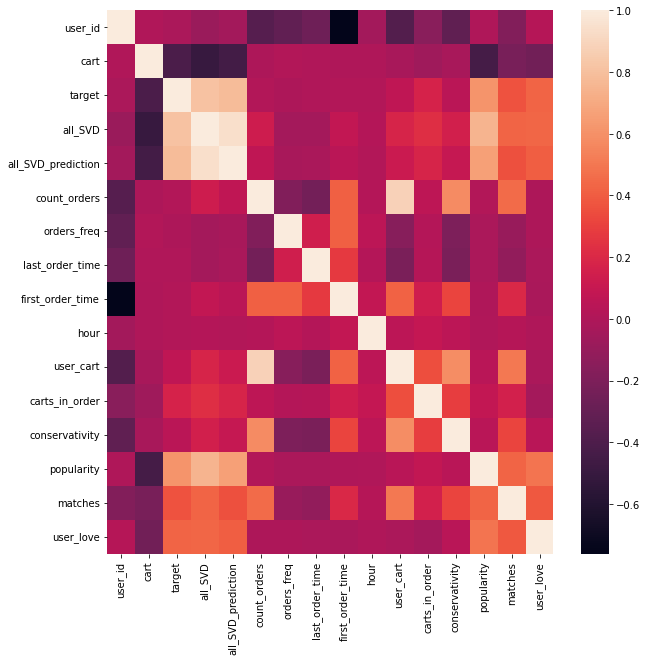

In [72]:
#Проверка корреляций
full_data_corr = full_data.corr()
plt.figure(figsize = (10, 10))
sns.heatmap(full_data_corr)

In [73]:
full_data_corr.target

user_id              -0.018514
cart                 -0.415529
target                1.000000
all_SVD               0.811250
all_SVD_prediction    0.780092
count_orders          0.013172
orders_freq          -0.010754
last_order_time       0.003348
first_order_time      0.015259
hour                  0.011130
user_cart             0.066098
carts_in_order        0.172946
conservativity        0.044900
popularity            0.613983
matches               0.362519
user_love             0.425663
Name: target, dtype: float64

In [74]:
X = full_data[['all_SVD', 'count_orders', 'orders_freq', 'last_order_time', 'first_order_time',
       'hour', 'user_cart', 'carts_in_order', 'conservativity', 'popularity',
       'matches', 'user_love']]
y = full_data['target']

In [75]:
# Стандартизация признаков
X_standard = StandardScaler().fit_transform(X)

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X_standard, y, random_state=42)

In [77]:
# Обучение модели
Logreg = LogisticRegression(penalty='l2', solver='liblinear').fit(X_train, y_train)

In [78]:
Logreg.score(X_train, y_train)

0.8969193931622753

In [79]:
Logreg.score(X_test, y_test)

0.8970342897323829

In [80]:
# Видно, что оценка улучшилась на 0,005, то есть логистическая регрессия оказалась полезной
f1_score(Logreg.predict(X_train), y_train)

0.894919558108374

In [81]:
#Оценка на тестовой выборке выше, т.е. модель не переучилась
f1_score(Logreg.predict(X_test), y_test)

0.8951388693869526

In [82]:
precision_score(Logreg.predict(X_train), y_train)

0.9088214443741347

In [83]:
precision_score(Logreg.predict(X_test), y_test)

0.9100512483761831

In [84]:
recall_score(Logreg.predict(X_train), y_train)

0.8814365675946306

In [85]:
recall_score(Logreg.predict(X_test), y_test)

0.8807073288664778

In [86]:
confusion_matrix(Logreg.predict(X_train), y_train)

array([[199299,  19164],
       [ 25694, 191017]], dtype=int64)

In [87]:
# Confusion matrix показывает равномерное распределение ответов по классам, что показывает стабильность модели
confusion_matrix(Logreg.predict(X_test), y_test)

array([[66372,  6301],
       [ 8635, 63750]], dtype=int64)

### Подготовка submission
Создаю все те же самые признаки, передаю все в SVD и потом получаю предсказание с помощью предобученной модели Logreg

In [96]:
train

,user_id,order_completed_at,cart,orders_num
0,2,2015-03-22 09:25:46,399,14
1,2,2015-03-22 09:25:46,14,14
2,2,2015-03-22 09:25:46,198,14
3,2,2015-03-22 09:25:46,88,14
4,2,2015-03-22 09:25:46,157,14
...,...,...,...,...
3123059,12702,2020-09-03 23:45:45,441,0
3123060,12702,2020-09-03 23:45:45,92,0
3123061,12702,2020-09-03 23:45:45,431,0
3123062,12702,2020-09-03 23:45:45,24,0


In [97]:
user_activity = train[['user_id', 'order_completed_at']].drop_duplicates().groupby(['user_id']).count().reset_index()
user_activity.rename(columns={'order_completed_at': 'count_orders'}, inplace=True)

train = train.merge(user_activity, how='left', on='user_id')
train

,user_id,order_completed_at,cart,orders_num,count_orders
0,2,2015-03-22 09:25:46,399,14,15
1,2,2015-03-22 09:25:46,14,14,15
2,2,2015-03-22 09:25:46,198,14,15
3,2,2015-03-22 09:25:46,88,14,15
4,2,2015-03-22 09:25:46,157,14,15
...,...,...,...,...,...
3123059,12702,2020-09-03 23:45:45,441,0,7
3123060,12702,2020-09-03 23:45:45,92,0,7
3123061,12702,2020-09-03 23:45:45,431,0,7
3123062,12702,2020-09-03 23:45:45,24,0,7


In [98]:
frequency = dict()
for user in train.user_id.unique():
    count_orders = train[train.user_id==user]['orders_num'].max()
    fin = datetime.strptime(train[train.user_id==user]['order_completed_at'].max(), '%Y-%m-%d %H:%M:%S')
    end = datetime.strptime(train[train.user_id==user]['order_completed_at'].min(), '%Y-%m-%d %H:%M:%S')
    delta = fin - end
    try:
        value = delta.days / (count_orders - 1)
    except ZeroDivisionError:
        value = 0
    frequency[user] = value

In [99]:
train['orders_freq'] = train.apply(lambda x: frequency[x.user_id], axis=1)
train

,user_id,order_completed_at,cart,orders_num,count_orders,orders_freq
0,2,2015-03-22 09:25:46,399,14,15,147.307692
1,2,2015-03-22 09:25:46,14,14,15,147.307692
2,2,2015-03-22 09:25:46,198,14,15,147.307692
3,2,2015-03-22 09:25:46,88,14,15,147.307692
4,2,2015-03-22 09:25:46,157,14,15,147.307692
...,...,...,...,...,...,...
3123059,12702,2020-09-03 23:45:45,441,0,7,26.800000
3123060,12702,2020-09-03 23:45:45,92,0,7,26.800000
3123061,12702,2020-09-03 23:45:45,431,0,7,26.800000
3123062,12702,2020-09-03 23:45:45,24,0,7,26.800000


In [100]:
last_order_time = dict()
for user in train.user_id.unique():
    date = datetime.strptime('2020-09-04 00:00:00', '%Y-%m-%d %H:%M:%S')
    last = datetime.strptime(train[train.user_id==user]['order_completed_at'].max(), '%Y-%m-%d %H:%M:%S')
    value = (date - last).days
    last_order_time[user] = value

In [101]:
train['last_order_time'] = train.apply(lambda x: last_order_time[x.user_id], axis=1)
train

,user_id,order_completed_at,cart,orders_num,count_orders,orders_freq,last_order_time
0,2,2015-03-22 09:25:46,399,14,15,147.307692,77
1,2,2015-03-22 09:25:46,14,14,15,147.307692,77
2,2,2015-03-22 09:25:46,198,14,15,147.307692,77
3,2,2015-03-22 09:25:46,88,14,15,147.307692,77
4,2,2015-03-22 09:25:46,157,14,15,147.307692,77
...,...,...,...,...,...,...,...
3123059,12702,2020-09-03 23:45:45,441,0,7,26.800000,0
3123060,12702,2020-09-03 23:45:45,92,0,7,26.800000,0
3123061,12702,2020-09-03 23:45:45,431,0,7,26.800000,0
3123062,12702,2020-09-03 23:45:45,24,0,7,26.800000,0


In [102]:
first_order_time = dict()
for user in train.user_id.unique():
    date = datetime.strptime('2020-09-04 00:00:00', '%Y-%m-%d %H:%M:%S')
    first = datetime.strptime(train[train.user_id==user]['order_completed_at'].min(), '%Y-%m-%d %H:%M:%S')
    value = (date - first).days
    first_order_time[user] = value

In [103]:
train['first_order_time'] = train.apply(lambda x: first_order_time[x.user_id], axis=1)
train

,user_id,order_completed_at,cart,orders_num,count_orders,orders_freq,last_order_time,first_order_time
0,2,2015-03-22 09:25:46,399,14,15,147.307692,77,1992
1,2,2015-03-22 09:25:46,14,14,15,147.307692,77,1992
2,2,2015-03-22 09:25:46,198,14,15,147.307692,77,1992
3,2,2015-03-22 09:25:46,88,14,15,147.307692,77,1992
4,2,2015-03-22 09:25:46,157,14,15,147.307692,77,1992
...,...,...,...,...,...,...,...,...
3123059,12702,2020-09-03 23:45:45,441,0,7,26.800000,0,134
3123060,12702,2020-09-03 23:45:45,92,0,7,26.800000,0,134
3123061,12702,2020-09-03 23:45:45,431,0,7,26.800000,0,134
3123062,12702,2020-09-03 23:45:45,24,0,7,26.800000,0,134


In [104]:
train['hour'] = train.apply(lambda x: datetime.strptime(x.order_completed_at, '%Y-%m-%d %H:%M:%S').hour, axis=1)
train

,user_id,order_completed_at,cart,orders_num,count_orders,orders_freq,last_order_time,first_order_time,hour
0,2,2015-03-22 09:25:46,399,14,15,147.307692,77,1992,9
1,2,2015-03-22 09:25:46,14,14,15,147.307692,77,1992,9
2,2,2015-03-22 09:25:46,198,14,15,147.307692,77,1992,9
3,2,2015-03-22 09:25:46,88,14,15,147.307692,77,1992,9
4,2,2015-03-22 09:25:46,157,14,15,147.307692,77,1992,9
...,...,...,...,...,...,...,...,...,...
3123059,12702,2020-09-03 23:45:45,441,0,7,26.800000,0,134,23
3123060,12702,2020-09-03 23:45:45,92,0,7,26.800000,0,134,23
3123061,12702,2020-09-03 23:45:45,431,0,7,26.800000,0,134,23
3123062,12702,2020-09-03 23:45:45,24,0,7,26.800000,0,134,23


In [105]:
order_time = dict()
for user in train.user_id.unique():
    datesum = 0
    count_orders = train[train.user_id==user]['orders_num'].max()
    for order in train[train.user_id==user]['order_completed_at'].drop_duplicates():
        hours = datetime.strptime(order, '%Y-%m-%d %H:%M:%S').hour
        minutes = datetime.strptime(order, '%Y-%m-%d %H:%M:%S').minute
        datesum += hours * 60
        datesum += minutes
    order_time[user] = datesum / count_orders / 60

In [106]:
train['hour'] = train.apply(lambda x: order_time[x.user_id], axis=1)
train

,user_id,order_completed_at,cart,orders_num,count_orders,orders_freq,last_order_time,first_order_time,hour
0,2,2015-03-22 09:25:46,399,14,15,147.307692,77,1992,17.652381
1,2,2015-03-22 09:25:46,14,14,15,147.307692,77,1992,17.652381
2,2,2015-03-22 09:25:46,198,14,15,147.307692,77,1992,17.652381
3,2,2015-03-22 09:25:46,88,14,15,147.307692,77,1992,17.652381
4,2,2015-03-22 09:25:46,157,14,15,147.307692,77,1992,17.652381
...,...,...,...,...,...,...,...,...,...
3123059,12702,2020-09-03 23:45:45,441,0,7,26.800000,0,134,15.755556
3123060,12702,2020-09-03 23:45:45,92,0,7,26.800000,0,134,15.755556
3123061,12702,2020-09-03 23:45:45,431,0,7,26.800000,0,134,15.755556
3123062,12702,2020-09-03 23:45:45,24,0,7,26.800000,0,134,15.755556


In [107]:
user_cart = train[['user_id', 'cart']].groupby(['user_id']).count().reset_index()
user_cart.rename(columns={'cart': 'user_cart'}, inplace=True)

train = train.merge(user_cart, how='left', on='user_id')
train

,user_id,order_completed_at,cart,orders_num,count_orders,orders_freq,last_order_time,first_order_time,hour,user_cart
0,2,2015-03-22 09:25:46,399,14,15,147.307692,77,1992,17.652381,172
1,2,2015-03-22 09:25:46,14,14,15,147.307692,77,1992,17.652381,172
2,2,2015-03-22 09:25:46,198,14,15,147.307692,77,1992,17.652381,172
3,2,2015-03-22 09:25:46,88,14,15,147.307692,77,1992,17.652381,172
4,2,2015-03-22 09:25:46,157,14,15,147.307692,77,1992,17.652381,172
...,...,...,...,...,...,...,...,...,...,...
3123059,12702,2020-09-03 23:45:45,441,0,7,26.800000,0,134,15.755556,188
3123060,12702,2020-09-03 23:45:45,92,0,7,26.800000,0,134,15.755556,188
3123061,12702,2020-09-03 23:45:45,431,0,7,26.800000,0,134,15.755556,188
3123062,12702,2020-09-03 23:45:45,24,0,7,26.800000,0,134,15.755556,188


In [108]:
train['carts_in_order'] = train.apply(lambda x: x.user_cart / x.count_orders, axis=1)

In [109]:
popularity = train[['cart', 'user_id']].groupby(['cart']).count().reset_index()
popularity.rename(columns={'user_id': 'popularity'}, inplace=True)
train = train.merge(popularity, how='left', on='cart')
train['popularity'] = train.apply(lambda x: x.popularity / len(train), axis=1)
train

,user_id,order_completed_at,cart,orders_num,count_orders,orders_freq,last_order_time,first_order_time,hour,user_cart,carts_in_order,popularity
0,2,2015-03-22 09:25:46,399,14,15,147.307692,77,1992,17.652381,172,11.466667,0.004381
1,2,2015-03-22 09:25:46,14,14,15,147.307692,77,1992,17.652381,172,11.466667,0.030085
2,2,2015-03-22 09:25:46,198,14,15,147.307692,77,1992,17.652381,172,11.466667,0.005670
3,2,2015-03-22 09:25:46,88,14,15,147.307692,77,1992,17.652381,172,11.466667,0.011119
4,2,2015-03-22 09:25:46,157,14,15,147.307692,77,1992,17.652381,172,11.466667,0.004887
...,...,...,...,...,...,...,...,...,...,...,...,...
3123059,12702,2020-09-03 23:45:45,441,0,7,26.800000,0,134,15.755556,188,26.857143,0.004063
3123060,12702,2020-09-03 23:45:45,92,0,7,26.800000,0,134,15.755556,188,26.857143,0.007903
3123061,12702,2020-09-03 23:45:45,431,0,7,26.800000,0,134,15.755556,188,26.857143,0.005308
3123062,12702,2020-09-03 23:45:45,24,0,7,26.800000,0,134,15.755556,188,26.857143,0.005125


In [110]:
matches = train[['user_id', 'cart', 'order_completed_at']].groupby(['user_id', 'cart']).count().reset_index()
matches.rename(columns={'order_completed_at': 'matches'}, inplace=True)
train = train.merge(matches, how='left', on=['user_id', 'cart'])
train

,user_id,order_completed_at,cart,orders_num,count_orders,orders_freq,last_order_time,first_order_time,hour,user_cart,carts_in_order,popularity,matches
0,2,2015-03-22 09:25:46,399,14,15,147.307692,77,1992,17.652381,172,11.466667,0.004381,1
1,2,2015-03-22 09:25:46,14,14,15,147.307692,77,1992,17.652381,172,11.466667,0.030085,1
2,2,2015-03-22 09:25:46,198,14,15,147.307692,77,1992,17.652381,172,11.466667,0.005670,2
3,2,2015-03-22 09:25:46,88,14,15,147.307692,77,1992,17.652381,172,11.466667,0.011119,2
4,2,2015-03-22 09:25:46,157,14,15,147.307692,77,1992,17.652381,172,11.466667,0.004887,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3123059,12702,2020-09-03 23:45:45,441,0,7,26.800000,0,134,15.755556,188,26.857143,0.004063,3
3123060,12702,2020-09-03 23:45:45,92,0,7,26.800000,0,134,15.755556,188,26.857143,0.007903,1
3123061,12702,2020-09-03 23:45:45,431,0,7,26.800000,0,134,15.755556,188,26.857143,0.005308,4
3123062,12702,2020-09-03 23:45:45,24,0,7,26.800000,0,134,15.755556,188,26.857143,0.005125,2


In [111]:
train['user_love'] = train.apply(lambda x: x.matches / x.user_cart, axis=1)
train

,user_id,order_completed_at,cart,orders_num,count_orders,orders_freq,last_order_time,first_order_time,hour,user_cart,carts_in_order,popularity,matches,user_love
0,2,2015-03-22 09:25:46,399,14,15,147.307692,77,1992,17.652381,172,11.466667,0.004381,1,0.005814
1,2,2015-03-22 09:25:46,14,14,15,147.307692,77,1992,17.652381,172,11.466667,0.030085,1,0.005814
2,2,2015-03-22 09:25:46,198,14,15,147.307692,77,1992,17.652381,172,11.466667,0.005670,2,0.011628
3,2,2015-03-22 09:25:46,88,14,15,147.307692,77,1992,17.652381,172,11.466667,0.011119,2,0.011628
4,2,2015-03-22 09:25:46,157,14,15,147.307692,77,1992,17.652381,172,11.466667,0.004887,2,0.011628
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3123059,12702,2020-09-03 23:45:45,441,0,7,26.800000,0,134,15.755556,188,26.857143,0.004063,3,0.015957
3123060,12702,2020-09-03 23:45:45,92,0,7,26.800000,0,134,15.755556,188,26.857143,0.007903,1,0.005319
3123061,12702,2020-09-03 23:45:45,431,0,7,26.800000,0,134,15.755556,188,26.857143,0.005308,4,0.021277
3123062,12702,2020-09-03 23:45:45,24,0,7,26.800000,0,134,15.755556,188,26.857143,0.005125,2,0.010638


In [112]:
conservativity = dict()
for user in train.user_id.unique():
    part_count = 0
    orders_count = train[train.user_id==user].orders_num.max()
    if orders_count == 1:
        conservativity[user] = 'NaN'
        continue
    previous_set = set(train[(train.user_id==user) & (train.orders_num == orders_count)]['cart'])
    for order in range(orders_count - 1, 0, -1):
        new_set = set(train[(train.user_id==user) & (train.orders_num == order)]['cart'])
        try:
            old_part = len(new_set.intersection(previous_set)) / len(new_set)
        except ZeroDivisionError:
            old_part = 0
        part_count += old_part
        previous_set.update(new_set)
    conservativity[user] = part_count / (orders_count - 1)

In [113]:
train['conservativity'] = train.apply(lambda x: conservativity[x.user_id], axis=1)
train

,user_id,order_completed_at,cart,orders_num,count_orders,orders_freq,last_order_time,first_order_time,hour,user_cart,carts_in_order,popularity,matches,user_love,conservativity
0,2,2015-03-22 09:25:46,399,14,15,147.307692,77,1992,17.652381,172,11.466667,0.004381,1,0.005814,0.691493
1,2,2015-03-22 09:25:46,14,14,15,147.307692,77,1992,17.652381,172,11.466667,0.030085,1,0.005814,0.691493
2,2,2015-03-22 09:25:46,198,14,15,147.307692,77,1992,17.652381,172,11.466667,0.005670,2,0.011628,0.691493
3,2,2015-03-22 09:25:46,88,14,15,147.307692,77,1992,17.652381,172,11.466667,0.011119,2,0.011628,0.691493
4,2,2015-03-22 09:25:46,157,14,15,147.307692,77,1992,17.652381,172,11.466667,0.004887,2,0.011628,0.691493
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3123059,12702,2020-09-03 23:45:45,441,0,7,26.800000,0,134,15.755556,188,26.857143,0.004063,3,0.015957,0.749336
3123060,12702,2020-09-03 23:45:45,92,0,7,26.800000,0,134,15.755556,188,26.857143,0.007903,1,0.005319,0.749336
3123061,12702,2020-09-03 23:45:45,431,0,7,26.800000,0,134,15.755556,188,26.857143,0.005308,4,0.021277,0.749336
3123062,12702,2020-09-03 23:45:45,24,0,7,26.800000,0,134,15.755556,188,26.857143,0.005125,2,0.010638,0.749336


In [114]:
all_pairs = np.transpose([np.tile(train['user_id'].unique(), len(train['cart'].unique())), np.repeat(train['cart'].unique(), len(train['user_id'].unique()))])

In [115]:
all_pairs = pd.DataFrame(all_pairs, columns = ['user_id', 'cart'])

In [116]:
train_for_rs = train[['user_id', 'cart']].drop_duplicates()
train_for_rs['target'] = train.apply(lambda x: 1, axis=1)
train_for_rs

,user_id,cart,target
0,2,399,1
1,2,14,1
2,2,198,1
3,2,88,1
4,2,157,1
...,...,...,...
3123042,12702,412,1
3123044,12702,423,1
3123048,12702,439,1
3123060,12702,92,1


In [117]:
diff_train = list(set(zip(all_pairs.user_id, all_pairs.cart)) - set(zip(train.user_id, train.cart)))
diff_train = random.sample(diff_train, k=3200_000)
print(len(diff_train), len(set(diff_train)))

3200000 3200000


In [118]:
diff_train = pd.DataFrame(diff_train, columns = ['user_id', 'cart'])
diff_train['target'] = diff_train.apply(lambda x: 0, axis=1)

In [119]:
full_train = pd.concat([train_for_rs, diff_train])

In [120]:
dataset = pd.DataFrame({
    'uid': full_train.user_id,
    'iid': full_train.cart,
    'rating': full_train.target,
})

In [121]:
reader = Reader(rating_scale=(0, 1))
data = Dataset.load_from_df(dataset, reader)

In [122]:
trainset = data.build_full_trainset()
algo = SVD(n_factors=30, n_epochs=102)
algo.fit(trainset)

In [138]:
#Пары, по которым надо сделать предсказание, получаю из sample_submission
test = sample_submission.id.str.split(';', n=2, expand=True)
test.columns = ['user_id', 'cart']
test.user_id = pd.to_numeric(test.user_id, downcast='integer')
test.cart = pd.to_numeric(test.cart, downcast='integer')
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790449 entries, 0 to 790448
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   user_id  790449 non-null  int16
 1   cart     790449 non-null  int16
dtypes: int16(2)
memory usage: 3.0 MB


In [144]:
test['all_SVD'] = test.apply(lambda x: algo.predict(uid=x['user_id'], iid=x['cart']).est, axis=1)
test

,user_id,cart,all_SVD
0,0,133,0.038434
1,0,5,0.717819
2,0,10,0.544832
3,0,396,0.593358
4,0,14,0.900184
...,...,...,...
790444,19998,26,0.371429
790445,19998,31,0.449401
790446,19998,29,0.515559
790447,19998,798,0.477905


In [131]:
user_info = train[['user_id', 'count_orders',
       'orders_freq', 'last_order_time', 'first_order_time', 'hour',
       'user_cart', 'carts_in_order', 'conservativity']].drop_duplicates()
user_info

,user_id,count_orders,orders_freq,last_order_time,first_order_time,hour,user_cart,carts_in_order,conservativity
0,2,15,147.307692,77,1992,17.652381,172,11.466667,0.691493
16,3,7,366.400000,71,1904,16.563889,62,8.857143,0.520000
18,4,8,312.833333,7,1884,11.797619,112,14.000000,0.497410
20,5,15,143.461538,5,1870,13.948810,116,7.733333,0.590451
32,6,10,227.500000,49,1870,18.120370,79,7.900000,0.529327
...,...,...,...,...,...,...,...,...,...
3054305,19998,3,3.000000,1,4,17.750000,19,6.333333,0.714286
3065480,14743,3,0.000000,3,3,15.200000,4,1.333333,1.000000
3072085,258,3,1.000000,1,3,21.483333,9,3.000000,0.200000
3074014,19999,3,0.000000,3,3,29.283333,3,1.000000,1.000000


In [132]:
cart_info = train[['cart', 'popularity']].drop_duplicates()
cart_info

,cart,popularity
0,399,4.380954e-03
1,14,3.008488e-02
2,198,5.669753e-03
3,88,1.111889e-02
4,157,4.886547e-03
...,...,...
3073344,789,3.201984e-07
3080649,752,3.201984e-07
3081146,325,3.201984e-07
3083916,332,1.280793e-06


In [133]:
pairs_info = train[['user_id', 'cart', 'matches', 'user_love']].drop_duplicates()
pairs_info

,user_id,cart,matches,user_love
0,2,399,1,0.005814
1,2,14,1,0.005814
2,2,198,2,0.011628
3,2,88,2,0.011628
4,2,157,2,0.011628
...,...,...,...,...
3123042,12702,412,1,0.005319
3123044,12702,423,1,0.005319
3123048,12702,439,1,0.005319
3123060,12702,92,1,0.005319


In [147]:
submission_data = test.merge(
    user_info, how='left', on='user_id').merge(
    cart_info, how='left', on='cart').merge(pairs_info, how='left', on=['user_id', 'cart'])
submission_data

,user_id,cart,all_SVD,count_orders,orders_freq,last_order_time,first_order_time,hour,user_cart,carts_in_order,conservativity,popularity,matches,user_love
0,0,133,0.038434,3,44.0,1,46,13.266667,44,14.666667,0.240000,0.000467,1,0.022727
1,0,5,0.717819,3,44.0,1,46,13.266667,44,14.666667,0.240000,0.009847,1,0.022727
2,0,10,0.544832,3,44.0,1,46,13.266667,44,14.666667,0.240000,0.004668,1,0.022727
3,0,396,0.593358,3,44.0,1,46,13.266667,44,14.666667,0.240000,0.008575,1,0.022727
4,0,14,0.900184,3,44.0,1,46,13.266667,44,14.666667,0.240000,0.030085,2,0.045455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
790444,19998,26,0.371429,3,3.0,1,4,17.750000,19,6.333333,0.714286,0.006422,1,0.052632
790445,19998,31,0.449401,3,3.0,1,4,17.750000,19,6.333333,0.714286,0.006150,1,0.052632
790446,19998,29,0.515559,3,3.0,1,4,17.750000,19,6.333333,0.714286,0.008856,1,0.052632
790447,19998,798,0.477905,3,3.0,1,4,17.750000,19,6.333333,0.714286,0.007245,1,0.052632


In [148]:
submission_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 790449 entries, 0 to 790448
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   user_id           790449 non-null  int16  
 1   cart              790449 non-null  int16  
 2   all_SVD           790449 non-null  float64
 3   count_orders      790449 non-null  int64  
 4   orders_freq       790449 non-null  float64
 5   last_order_time   790449 non-null  int64  
 6   first_order_time  790449 non-null  int64  
 7   hour              790449 non-null  float64
 8   user_cart         790449 non-null  int64  
 9   carts_in_order    790449 non-null  float64
 10  conservativity    790449 non-null  float64
 11  popularity        790449 non-null  float64
 12  matches           790449 non-null  int64  
 13  user_love         790449 non-null  float64
dtypes: float64(7), int16(2), int64(5)
memory usage: 81.4 MB


In [150]:
X = submission_data[['all_SVD', 'count_orders', 'orders_freq', 'last_order_time', 'first_order_time',
       'hour', 'user_cart', 'carts_in_order', 'conservativity', 'popularity',
       'matches', 'user_love']]

In [152]:
X_standard = StandardScaler().fit_transform(X)

In [158]:
submission_data['target'] = Logreg.predict(X_standard)

In [159]:
submission_data

,user_id,cart,all_SVD,count_orders,orders_freq,last_order_time,first_order_time,hour,user_cart,carts_in_order,conservativity,popularity,matches,user_love,target
0,0,133,0.038434,3,44.0,1,46,13.266667,44,14.666667,0.240000,0.000467,1,0.022727,0
1,0,5,0.717819,3,44.0,1,46,13.266667,44,14.666667,0.240000,0.009847,1,0.022727,1
2,0,10,0.544832,3,44.0,1,46,13.266667,44,14.666667,0.240000,0.004668,1,0.022727,0
3,0,396,0.593358,3,44.0,1,46,13.266667,44,14.666667,0.240000,0.008575,1,0.022727,1
4,0,14,0.900184,3,44.0,1,46,13.266667,44,14.666667,0.240000,0.030085,2,0.045455,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
790444,19998,26,0.371429,3,3.0,1,4,17.750000,19,6.333333,0.714286,0.006422,1,0.052632,0
790445,19998,31,0.449401,3,3.0,1,4,17.750000,19,6.333333,0.714286,0.006150,1,0.052632,0
790446,19998,29,0.515559,3,3.0,1,4,17.750000,19,6.333333,0.714286,0.008856,1,0.052632,0
790447,19998,798,0.477905,3,3.0,1,4,17.750000,19,6.333333,0.714286,0.007245,1,0.052632,0


In [162]:
#Привожу результат к формату sample_submission
ids = submission_data[['user_id', 'cart']].apply(lambda x: str(x.user_id) + ';' + str(x.cart), axis = 1)
ids

0             0;133
1               0;5
2              0;10
3             0;396
4              0;14
            ...    
790444     19998;26
790445     19998;31
790446     19998;29
790447    19998;798
790448    19998;415
Length: 790449, dtype: object

In [168]:
sample_submission = pd.DataFrame(data = {'id': ids, 'target':submission_data['target']})
sample_submission

,id,target
0,0;133,0
1,0;5,1
2,0;10,0
3,0;396,1
4,0;14,1
...,...,...
790444,19998;26,0
790445,19998;31,0
790446,19998;29,0
790447,19998;798,0


In [169]:
sample_submission.to_csv(r'sample_submission.csv', index=False, header=True)

In [170]:
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission

,id,target
0,0;133,0
1,0;5,1
2,0;10,0
3,0;396,1
4,0;14,1
...,...,...
790444,19998;26,0
790445,19998;31,0
790446,19998;29,0
790447,19998;798,0
